## Comparison of models performance of explored and selected feature spaces when having GENES EXPRESSION VALUES as features

**In this notebook all the combinations of models, datasets, preprocessing methods done until now will be joined together. The focus will be on scalability, dinamicity and correct saving of the results.**







USEFUL LINKS:

https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel

### Imports section: 


In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/Drive')

Mounted at /content/Drive


In [ ]:
# uncomment to install libraries
# ! pip install mrmr_selection
# ! pip install scikit-learn==0.24.2 # Downgrading the scikit learn library to obtain same results of previous experiments and Convergence

In [3]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression, Lasso
import matplotlib.pyplot as plt
from xlwt import Workbook
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import os
from pandas_profiling import ProfileReport
from sklearn import svm
from sklearn.svm import SVC
from datetime import datetime
from sklearn.feature_selection import SelectFromModel
import mrmr
# select top K features using mRMR
from mrmr import mrmr_classif

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Retrieval of Gene Expression Data and comparison with Isoform Datasets

### Download of all datasets with different preprocessing strategies and feature spaces

In [40]:
# Current working directory and other paths
cwd = os.getcwd()
print(cwd)
!cd Drive/
path = cwd + "/Drive/My Drive/magistrale/BioinformaticsProject/data/"
results_path = cwd + "/Drive/My Drive/magistrale/BioinformaticsProject/results/"

# Dataset with gene expression 
gene_dataset = pd.read_csv(path+"gene_expression_data_and_metadata/data_mrna_seq_v2_rsem.txt" , index_col= 0 , sep='\t') 
gene_dataset = gene_dataset.transpose() # (818, 20440)
# remove first column about entrez_gene_id
gene_dataset = gene_dataset.iloc[1: , :]
print(gene_dataset.shape)
# Training and Testing datasets
training_ds =  pd.read_excel(path+"train_test_new.xlsx", sheet_name="train_new")
testing_ds = pd.read_excel(path+"train_test_new.xlsx", sheet_name="test_new")

/content
(818, 20440)


In [41]:
# feature spaces 
pam_fs =  pd.read_csv(path+"gene_expression_data_and_metadata/PAM50.txt" , index_col= 0 , sep='\t') 
limma_fs =  pd.read_csv(path+"gene_expression_data_and_metadata/LIMMA50.txt" , index_col= 0 , sep='\t') 

pam_fs.reset_index(inplace=True)
limma_fs.reset_index(inplace=True)

### create the cpm

In [44]:
cpm_dataset_1 = gene_dataset.div(gene_dataset.sum(axis=1), axis=0)
cpm_dataset_end = cpm_dataset_1 * 1000000
cpm_dataset = cpm_dataset_end
cpm_dataset.shape

(817, 20440)

In [ ]:
cpm_dataset.columns.name = ''
cpm_dataset.index.rename('sample_id', inplace=True)
cpm_dataset.index = cpm_dataset.index.str[: -3] # removal of -01 from cpm sample id which is not relevant for recognition
cpm_dataset.head()

In [46]:
# don't reset index since the sample ids have to be the indexes
# cpm_dataset.reset_index(inplace=True)

### filtering the genes that have expression data at the beginning lower than 4 for more than 80% of the samples.

In [ ]:
y = (gene_dataset[gene_dataset < 4].count() /818 > 0.8)
y = y[y==True]
y = y.reset_index()
print(y[''])

In [49]:
gene_dataset.drop(y[''], axis=1, inplace=True)
gene_dataset.head()

In [ ]:
cpm_dataset.drop(y[''], axis=1, inplace=True)
cpm_dataset.head()

### Evaluation of the median values

In [131]:
med = cpm_dataset.median()
med.sort_values(inplace=True)
md = pd.DataFrame(med)
md.describe()

,0
count,12385.000000
mean,67.930497
std,161.769492
min,1.771260
25%,14.313548
50%,32.231245
75%,69.246955
max,5606.966389


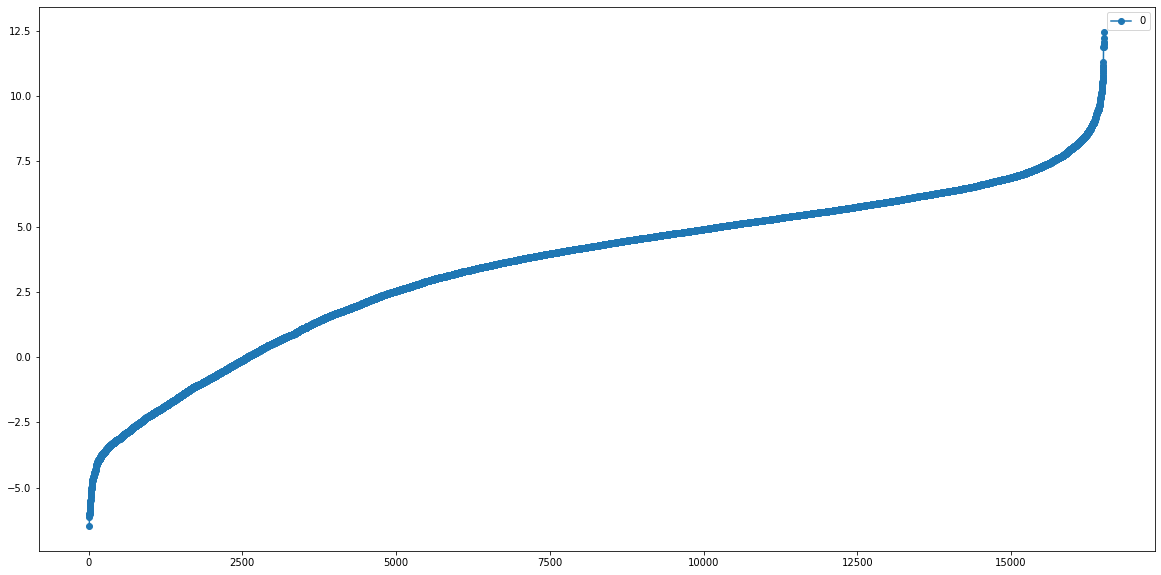

In [53]:
%matplotlib inline
log_md = np.log2(md)
log_md.reset_index(drop=True).plot(figsize=(15,7), style='o-')

In [ ]:
md = md[md>3.38].dropna(inplace=True)
gene_to_keep_by_median = md.index.tolist()
gene_to_keep_by_median

In [77]:
len(np.intersect1d(cpm_dataset.columns, gene_to_keep_by_median))


12381

In [79]:
# keeping just the filtered by removing the ones with median value lower than the 25% from the describe
cpm_dataset = cpm_dataset[np.intersect1d(cpm_dataset.columns, gene_to_keep_by_median)]

In [80]:
cpm_dataset.head()

,A1BG,A1BG-AS1,A2M,A4GALT,AAAS,AACS,AAED1,AAGAB,AAK1,AAMDC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SB-01,2.493770,3.801738,1603.081519,17.103149,36.078739,110.702352,6.005511,43.020468,53.136219,7.750306,...,24.064519,16.281099,4.863782,26.328346,71.769285,0.981892,69.166137,313.588163,97.892120,72.796846
TCGA-A1-A0SD-01,7.670497,7.743075,1282.579083,20.329587,28.425758,42.299809,8.666822,105.232365,59.579958,27.801602,...,20.076537,34.970458,5.189397,31.172037,66.071162,1.783299,46.793718,191.882778,68.942268,64.448359
TCGA-A1-A0SE-01,10.234784,7.888537,834.862431,14.131281,33.782319,44.123136,5.519757,87.530094,53.782712,19.004741,...,23.436790,43.040141,5.065602,38.568442,54.079661,3.056830,50.987894,159.653775,49.171264,57.084085
TCGA-A1-A0SF-01,17.274740,9.924330,825.746478,23.380748,53.276323,23.471546,4.721547,53.367122,35.139223,16.434623,...,14.153295,35.865614,3.927056,28.261196,55.818696,5.016646,46.693397,283.134039,49.508164,26.921912
TCGA-A1-A0SH-01,7.732152,6.762265,600.218980,14.943977,22.470162,35.168673,5.001973,58.041472,50.979863,11.862264,...,17.245967,14.851062,3.763095,24.916952,34.363403,0.851729,58.025988,234.333928,56.291558,42.927153


In [86]:
cpm_dataset.shape

(817, 12385)

In [87]:
def extract_and_reduce_by_columns(full_df, nofeats_ds, preproc_strategy: str= "none"): 
  """
     Function to extract dataset and a specific group of its columns.

     path: the path where to get the data values (isoforms)
     sheet_name: the excel sheet were to get the columns to select for the data (isoforms)
     nofeats_ds: the dataset without the additional columns
     name: 'trainingset' or 'testingset' for the excel 
     preproc_strategy: which preprocessing strategy to apply to the ds

  """
  full_df = full_df # path of subdatset 
  full_list= full_df['Genes'].values.tolist()  #exatrct the list of isoforms names as list
  if preproc_strategy == 'loge':
    # https://stackoverflow.com/questions/49538185/purpose-of-numpy-log1p
    log_cpm_dataset = np.log1p(cpm_dataset)
    data = log_cpm_dataset[np.intersect1d(log_cpm_dataset.columns, full_list)]
  elif preproc_strategy == 'log2':
    log_cpm_dataset = np.log2(cpm_dataset + 1) # constant added to avoid reaching zero
    data = log_cpm_dataset[np.intersect1d(log_cpm_dataset.columns, full_list)]
  elif preproc_strategy == 'normperrow':
    # normalize per rows
    data = cpm_dataset[np.intersect1d(cpm_dataset.columns, full_list)]
    data = data.div(data.sum(axis=1), axis=0) # ----> preprocessing scaling step to try, not working
  elif preproc_strategy == 'none':
    data = cpm_dataset[np.intersect1d(cpm_dataset.columns, full_list)]  # find the mutual isoform between main datset and subdatset 
    
  
  #data.reset_index(inplace=True) # todo remove
  #data.rename(columns={ data.columns[0]: "sample_id" }, inplace = True) 
  # print("hello", data.index)
  x = nofeats_ds['sample_id'].values.tolist()
  data1= data.loc[data.index.isin(x)]
  # print("hello11", data1)
  result = pd.merge(data1, nofeats_ds, on='sample_id')
  result
  result.rename(columns={'sample_label':'subtype'}, inplace=True )
 
  # result.to_csv(name +".csv", index=False) # save as csv file 
  return result

 DATASET 1 CON FS PAM50
 

In [88]:
# List of feature space name 
feature_space_files =["FEATURE_SPACE6(MAIN)", "FEATURE_SPACE1(PAM)", "FEATURE_SPACE2(PAM)","FEATURE_SPACE1(LIMMA)","FEATURE_SPACE2(LIMMA)", "FEATURE_SPACE7(pamsimilarity)","FEATURE_SPACE8(limmasimilarity)"]

In [89]:
# Training Data import:
train = extract_and_reduce_by_columns(pam_fs, training_ds, 'none') 
# print("aloha", train)
X_train_pam = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_pam = train.subtype
print("X_train size:", X_train_pam.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(pam_fs, testing_ds,'none' ) 
X_test_pam = test.drop(["sample_id","subtype"], axis = 1)
Y_test_pam = test.subtype
print("X_test size:", X_test_pam.shape)

X_train size: (410, 49)
X_test size: (127, 49)


DATASET 2 CON FS LIMMA50

In [90]:
# Training Data import:
train = extract_and_reduce_by_columns(limma_fs, training_ds, 'none' ) 
X_train_limma = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_limma =train.subtype
print("X_train size:", X_train_limma.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(limma_fs, testing_ds, 'none') 
X_test_limma = test.drop(["sample_id","subtype"], axis = 1)
Y_test_limma = test.subtype
print("X_test size:", X_test_limma.shape)

X_train size: (410, 185)
X_test size: (127, 185)


DATASET 3 CON FS PAM50 E LOGE PREPROC




In [91]:
# Training Data import:
train = extract_and_reduce_by_columns(pam_fs, training_ds, 'loge') 
X_train_pam_loge = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_pam_loge=train.subtype
print("X_train size:", X_train_pam_loge.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(pam_fs, testing_ds, 'loge') 
X_test_pam_loge = test.drop(["sample_id","subtype"], axis = 1)
Y_test_pam_loge = test.subtype
print("X_test size:", X_test_pam_loge.shape)

X_train size: (410, 49)
X_test size: (127, 49)


DATASET 4 CON FS LIMMA50 E LOGE PREPROC

In [92]:
# Training Data import:
train = extract_and_reduce_by_columns(limma_fs, training_ds, 'loge' ) 
X_train_limma_loge = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_limma_loge =train.subtype
print("X_train size:", X_train_limma_loge.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(limma_fs, testing_ds, 'loge' ) 
X_test_limma_loge = test.drop(["sample_id","subtype"], axis = 1)
Y_test_limma_loge = test.subtype
print("X_test size:", X_test_limma_loge.shape)

X_train size: (410, 185)
X_test size: (127, 185)


DATASET 5 CON FS PAM50 E LOG2 PREPROC

In [93]:
# Training Data import:
train = extract_and_reduce_by_columns(pam_fs, training_ds, 'log2') 
X_train_pam_log2 = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_pam_log2 =train.subtype
print("X_train size:", X_train_pam_log2.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(pam_fs, testing_ds, 'none') 
X_test_pam_log2 = test.drop(["sample_id","subtype"], axis = 1)
Y_test_pam_log2 = test.subtype
print("X_test size:", X_test_pam_log2.shape)

X_train size: (410, 49)
X_test size: (127, 49)


DATASET 6 CON FS LIMMA50 E LOG2 PREPROC

In [94]:
# Training Data import:
train = extract_and_reduce_by_columns(limma_fs, testing_ds, 'log2') 
X_train_limma_log2 = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_limma_log2 =train.subtype
print("X_train size:", X_train_limma_log2.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(limma_fs, testing_ds, 'log2') 
X_test_limma_log2 = test.drop(["sample_id","subtype"], axis = 1)
Y_test_limma_log2 = test.subtype
print("X_test size:", X_test_limma_log2.shape)

X_train size: (127, 185)
X_test size: (127, 185)


DATASET 7 CON FS REDUCED FROM PAM50 E LOG PREPROCESSING (choose the best between 2 and e)

In [95]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(X_train_pam_log2,Y_train_pam_log2)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

In [96]:
sel_.get_support()
selected_feat = X_train_pam_loge.columns[(sel_.get_support())]

In [97]:
print('total features: {}'.format((X_train_pam_loge.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('Percentage features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_ == 0)/131*5))

total features: 49
selected features: 48
Percentage features with coefficients shrank to zero: 4.0458015267175576


In [99]:
X_train_pam_log2_sel = X_train_pam_log2[selected_feat].copy()
Y_train_pam_log2_sel = Y_train_pam_log2

X_test_pam_log2_sel = X_test_pam_log2[selected_feat].copy()
Y_test_pam_log2_sel = Y_test_pam_log2

DATASET 8 CON FS REDUCED FROM LIMMA50 E LOG PREPROCESSING (choose the best between 2 and e)

In [100]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(X_train_limma_log2,Y_train_limma_log2)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

In [101]:
sel_.get_support()
selected_feat = X_train_limma.columns[(sel_.get_support())]

In [102]:
print('total features: {}'.format((X_train_limma_loge.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('Percentage features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_ == 0)/557*5))

total features: 185
selected features: 91
Percentage features with coefficients shrank to zero: 7.127468581687612


In [103]:
X_train_limma_log2_sel = X_train_limma_log2[selected_feat].copy()
Y_train_limma_log2_sel = Y_train_limma_log2

X_test_limma_log2_sel = X_test_limma_log2[selected_feat].copy()
Y_test_limma_log2_sel = Y_test_limma_log2

DATASET 9 CON FS NEW E LOG PREPROCESSING (choose best try 2 for now) 

#### feature selection on all features

In [ ]:
from scipy.optimize.optimize import main
main_filtered_gene_fs = pd.DataFrame({'Genes': cpm_dataset.columns.tolist()})

In [114]:
# Training Data import:
train = extract_and_reduce_by_columns(main_filtered_gene_fs, training_ds, 'log2') 
X_train_lasso = train.drop(["sample_id","subtype"],  axis = 1)
samples_train = train.sample_id
Y_train_lasso=train.subtype
print("X_train size:", X_train_lasso.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(main_filtered_gene_fs, testing_ds,  'log2') 
X_test_lasso = test.drop(["sample_id","subtype"], axis = 1)
Y_test_lasso = test.subtype
print("X_test size:", X_test_lasso.shape)

X_train size: (410, 12385)
X_test size: (127, 12385)


In [115]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(X_train_lasso,Y_train_lasso)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

In [ ]:
sel_.get_support()
selected_feat = X_train_lasso.columns[(sel_.get_support())]
print(sel_.estimator_.coef_)

In [117]:
print('total features: {}'.format((X_train_lasso.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

perc_feat_selected = np.sum(sel_.estimator_.coef_ == 0)/ (49740*5)
print(perc_feat_selected)

total features: 12385
selected features: 1074
coefficients shrank to zero: 60491
0.24322878970647366


In [118]:
X_train_lasso = X_train_lasso[selected_feat].copy()
Y_train_lasso = Y_train_lasso

X_test_lasso = X_test_lasso[selected_feat].copy()
Y_test_lasso = Y_test_lasso

## MRMR

In [121]:
mrmr_features = mrmr_classif(X=X_train_lasso, y=Y_train_lasso, K=750)

# Next steps: check how many of the chosen features overlap with selected with lasso, pam50 and limam50
# in other training notebook: check how the models perform on it 

100%|██████████| 750/750 [04:25<00:00,  2.83it/s]


In [122]:
print(mrmr_features)

['FOXA1', 'G6PD', 'SPON2', 'MLPH', 'ESR1', 'SPDEF', 'FOXC1', 'AGR3', 'SLC44A4', 'CA12', 'MIEN1', 'GATA3', 'AGR2', 'XBP1', 'CCNE2', 'THSD4', 'STARD3', 'PRR15', 'CCDC170', 'TPX2', 'DNALI1', 'DEGS2', 'GRB7', 'C5AR2', 'B3GNT5', 'POLQ', 'RGMA', 'NDC80', 'CDC20', 'ERBB2', 'ZNF552', 'CCNE1', 'TFF3', 'CEP55', 'PGAP3', 'GREB1', 'ERBB4', 'SGOL1', 'AR', 'GABRP', 'SKA1', 'HID1', 'TICRR', 'SFRP1', 'SCUBE2', 'FSCN1', 'EXO1', 'ANXA9', 'PSMD3', 'C9orf152', 'MAPT', 'LMX1B', 'TTK', 'KCNK5', 'DEPDC1B', 'ARMT1', 'UBE2C', 'RERG', 'ORMDL3', 'ABAT', 'KIF18B', 'SUSD3', 'YBX1', 'AURKA', 'CLSTN2', 'BIRC5', 'GFRA1', 'AFF3', 'CDCA2', 'CDCA7', 'GATA3-AS1', 'MELK', 'CRYAB', 'FAM214A', 'UBE2T', 'CELSR1', 'MCM10', 'CENPE', 'MAP2', 'GINS1', 'BCAS1', 'NAT1', 'MFI2', 'SLC39A6', 'SERPINB5', 'FAM83D', 'SPAG5', 'TRIM3', 'FSIP1', 'KIF18A', 'TMEM63C', 'KIFC1', 'TFF1', 'IGF1R', 'TMEM45B', 'FAT2', 'MYBL2', 'PGR', 'TRIM2', 'DEPDC1', 'ABCA12', 'KIF14', 'KRT6B', 'UBXN10', 'CREB3L4', 'NUF2', 'DSC3', 'ANLN', 'TFCP2L1', 'KIF20A', 'I

In [123]:
X_train_mrmr = X_train_lasso[mrmr_features].copy()
Y_train_mrmr = Y_train_lasso

X_test_mrmr = X_test_lasso[mrmr_features].copy()
Y_test_mrmr = Y_test_lasso

In [124]:
print(X_train_mrmr.shape, X_test_mrmr.shape)

(410, 750) (127, 750)


### Model training, evaluation and saving of results


In [125]:
def write_results(results, final_path, name_file):
      '''
      Function to write results metrics and confing into a csv file with as name the current date
      '''
      
      # datetime object containing current date and time
      now = datetime.now()
      dt_string = now.strftime("%d%m%Y%H%M%S")
      dt = now.strftime("%d%m%Y")

      if not os.path.exists(results_path+final_path+dt+'/'):
        os.mkdir(results_path+final_path+dt+'/')

      
      df = pd.DataFrame(results)
      df.to_csv(results_path+final_path+dt+'/'+name_file+dt_string+".csv")

In [126]:
def training_and_saving_after_cv_and_single_split(which_ds, X_train, Y_train,X_test, Y_test, scores, param_values, model):

  C = []
  l1_ratio = []
  cv_best = []
  score_test_balanced_accuracy = []
  score_test_accuracy = []
  precision = []
  recall = []
  f1=[]

  for index, score in enumerate(scores):
      # -------RESULTS in CROSS_VALIDATION-----------
      print("Tuning hyper-parameters for %s" % score)
      # Fit and hyperparameter search
      selected_model = GridSearchCV(model(), param_values, scoring=score, cv=10)
      selected_model.fit(X_train, Y_train)
      # found best model and fit on training
      print("Parameter setting that gave the best results on the hold out data: ",  selected_model.best_params_)
      print("Mean cross-validated score of the best_estimator found: ",  selected_model.best_score_)

      # save top config and score from grid search (only accuracy or balanced accuracy)
      # evaltype datasetdetails modelname parameters balancedaccuracy
      dic_result = {}
      dic_result['eval_type']= ['GRID SEARCH RESULTS']
      dic_result['dataset_details']= [which_ds]
      dic_result['model_name']=  [model.__name__ ]
      dic_result['top_parameters']= [str(selected_model.best_params_)]
      dic_result['name_score']= [score]
      dic_result['score_value'] = [selected_model.best_score_]
      df_result = pd.DataFrame.from_dict(dic_result)
      print('Grid search results: ', df_result)
      write_results(df_result,model.__name__ +'/', 'cv_on_'+score)

      # use top config and trained model for evaluation on test
      y_true, y_pred = Y_test, selected_model.predict(X_test)

      # save results from test
      # evaltype datasetdetails modelname parameters balacc accc prec rec f1
      dic_result = {}
      dic_result['eval_type']= ['TEST GRID SEARCH RESULTS']
      dic_result['dataset_details']= [which_ds]
      dic_result['model_name']=  [model.__name__ ]
      dic_result['top_parameters']= [str(selected_model.best_params_)]
      dic_result['balanced_accuracy'] = [round(balanced_accuracy_score(y_true, y_pred), 3)]
      dic_result['accuracy'] = [round(accuracy_score(y_true, y_pred), 3)]
      dic_result['precision'] = [round(precision_score(y_true, y_pred, average="macro"), 3)]
      dic_result['recall'] = [round(recall_score(y_true, y_pred, average="macro"), 3)]
      dic_result['f1'] = [round(f1_score(y_true, y_pred, average="macro"),3)]

      df_result = pd.DataFrame.from_dict(dic_result)
      print('Grid search results on test eval: ', df_result)
      # not saved anymore because the results are the same as creating new model and performing eval on test set
      # it was initiially introduced for verification
      # write_results(df_result,model.__name__ +'/', 'testcv_on_'+score) 

      # create new model with top convig and evaluate for verification
      check_model = model(**selected_model.best_params_)
      check_model.fit(X_train, Y_train)
      
      y_true, y_pred = Y_test, check_model.predict(X_test)

      # save again the scores
      dic_result = {}
      dic_result['eval_type']= ['TEST GRID SEARCH RESULTS']
      dic_result['dataset_details']= [which_ds]
      dic_result['model_name']=  [model.__name__ ]
      dic_result['top_parameters']= [str(selected_model.best_params_)]
      dic_result['balanced_accuracy'] = [round(balanced_accuracy_score(y_true, y_pred), 3)]
      dic_result['accuracy'] = [round(accuracy_score(y_true, y_pred), 3)]
      dic_result['precision'] = [round(precision_score(y_true, y_pred, average="macro"), 3)]
      dic_result['recall'] = [round(recall_score(y_true, y_pred, average="macro"), 3)]
      dic_result['f1'] = [round(f1_score(y_true, y_pred, average="macro"),3)]
      
      df_result = pd.DataFrame.from_dict(dic_result)
      print('Results on test eval: ', df_result)
      write_results(df_result,model.__name__ +'/', 'test_on_'+score)

### Running section

In [ ]:
# for each dataset
# for each model
# create all parameters and other details to pass to the fun
# run training and saving function 

Parameters definition

In [ ]:
# Configuration of parameters and name

#GridSearch attributes
# Set the parameters by cross-validation
#'l1_ratio':[0.5], 'solver': ['saga'], 'penalty':['elasticnet']
logreg_tuned_parameters = [{
    'multi_class':  ['ovr'],
    'penalty':['elasticnet'],
    'solver': ['saga'], 
    'max_iter':[2000], 
    'C':  [ 0.1, 0.01], #[10 ** i for i in range(-2,1)],
    'l1_ratio': [ 0.01, 0.001] #[10 ** i for i in range(-2,1)] #'l1_ratio':[0.5]}]
    }]

svc_tuned_parameters = [{
    'kernel':['poly'], 
    'degree': [1, 2, 3], 
    'gamma': [10 ** i for i in range(-3,3)],
    'max_iter':[1000], 
    'C': [10 ** i for i in range(-3,3)]}]

scores = [ "accuracy", "balanced_accuracy"]

print(logreg_tuned_parameters)
print(svc_tuned_parameters)

[{'multi_class': ['ovr'], 'penalty': ['elasticnet'], 'solver': ['saga'], 'max_iter': [2000], 'C': [0.1, 0.01], 'l1_ratio': [0.01, 0.001]}]
[{'kernel': ['poly'], 'degree': [1, 2, 3], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [1000], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


dataset 1 with fs pam50

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('pam_fs', X_train_pam, Y_train_pam, X_test_pam, Y_test_pam, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('pam_fs', X_train_pam, Y_train_pam, X_test_pam, Y_test_pam, scores, svc_tuned_parameters, SVC)

dataset 2 with fs limma50

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('limma_fs', X_train_limma, Y_train_limma, X_test_limma, Y_test_limma, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('limma_fs', X_train_limma, Y_train_limma, X_test_limma, Y_test_limma, scores, svc_tuned_parameters, SVC)

dataset 3 with fs pam50 and loge preprocessing

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('pam_fs_loge', X_train_pam_loge, Y_train_pam_loge, X_test_pam_loge, Y_test_pam_loge, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('pam_fs_loge', X_train_pam_loge, Y_train_pam_loge, X_test_pam_loge, Y_test_pam_loge, scores, svc_tuned_parameters, SVC)

dataset 4 with fs limma50 and loge preprocessing

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('limma_fs_loge', X_train_limma_loge, Y_train_limma_loge, X_test_limma_loge, Y_test_limma_loge, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('limma_fs_loge', X_train_limma_loge, Y_train_limma_loge, X_test_limma_loge, Y_test_limma_loge, scores, svc_tuned_parameters, SVC)

dataset 5 with fs pam50 and log2 preprocessing

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('pam_fs_log2', X_train_pam_log2, Y_train_pam_log2, X_test_pam_log2, Y_test_pam_log2, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('pam_fs_log2', X_train_pam_log2, Y_train_pam_log2, X_test_pam_log2, Y_test_pam_log2, scores, svc_tuned_parameters, SVC)

dataset 6 with fs limma50 and log2 preprocessing

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('limma_fs_log2', X_train_limma_log2, Y_train_limma_log2, X_test_limma_log2, Y_test_limma_log2, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('limma_fs_log2', X_train_limma_log2, Y_train_limma_log2, X_test_limma_log2, Y_test_limma_log2, scores, svc_tuned_parameters, SVC)

DATASET 7 CON FS REDUCED FROM PAM50 E LOG PREPROCESSING (choose the best between 2 and e)



In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('pam_fs_loge_sel', X_train_pam_loge_sel, Y_train_pam_loge_sel, X_test_pam_loge_sel, Y_test_pam_loge_sel, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('pam_fs_loge_sel', X_train_pam_loge_sel, Y_train_pam_loge_sel, X_test_pam_loge_sel, Y_test_pam_loge_sel, scores, svc_tuned_parameters, SVC)

DATASET 8 CON FS REDUCED FROM LIMMA50 E LOG PREPROCESSING (choose the best between 2 and e)

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('limma_fs_loge_sel', X_train_limma_loge_sel, Y_train_limma_loge_sel, X_test_limma_loge_sel, Y_test_limma_loge_sel, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC

training_and_saving_after_cv_and_single_split('limma_fs_loge_sel', X_train_limma_loge_sel, Y_train_limma_loge_sel, X_test_limma_loge_sel, Y_test_limma_loge_sel, scores, svc_tuned_parameters, SVC)

DATASET 9 CON FS NEW E LOG PREPROCESSING (choose best try e for now)

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('lasso_fs_loge_sel', X_train_lasso, Y_train_lasso, X_test_lasso, Y_test_lasso, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('lasso_fs_loge_sel', X_train_lasso, Y_train_lasso, X_test_lasso, Y_test_lasso, scores, svc_tuned_parameters, SVC)

### DATASET 10 CON FS NEW with mrmr for feature space E LOG PREPROCESSING (choose best try e for now)

In [ ]:
# EVALUATION with LOGISTIC REGRESSION
training_and_saving_after_cv_and_single_split('mrmr_fs_log2_sel', X_train_mrmr, Y_train_mrmr, X_test_mrmr, Y_test_mrmr, scores, logreg_tuned_parameters, LogisticRegression)

# EVALUATION with SVC
training_and_saving_after_cv_and_single_split('mnrmr_fs_log2_sel', X_train_mrmr, Y_train_mrmr, X_test_mrmr, Y_test_mrmr, scores, svc_tuned_parameters, SVC)

### Random Forest Classifier exploration

In [ ]:
# EVALUATION with RandomForrest
from sklearn.ensemble import RandomForestClassifier
rf_values= [{
    'criterion': ['gini', 'log_loss'],
    'min_samples_split': [2,5,10],
    'bootstrap': [True, False],
    'max_depth': [ 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 600, 800,1200]
    }]



Tuning hyper-parameters for accuracy


In [ ]:
# dataset 1
training_and_saving_after_cv_and_single_split('pam_fs', X_train_pam, Y_train_pam, X_test_pam, Y_test_pam, scores,rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 2
training_and_saving_after_cv_and_single_split('limma_fs', X_train_limma, Y_train_limma, X_test_limma, Y_test_limma, scores, rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 3
training_and_saving_after_cv_and_single_split('pam_fs_loge', X_train_pam_loge, Y_train_pam_loge, X_test_pam_loge, Y_test_pam_loge, scores, rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 4
training_and_saving_after_cv_and_single_split('limma_fs_loge', X_train_limma_loge, Y_train_limma_loge, X_test_limma_loge, Y_test_limma_loge, scores, rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 5
training_and_saving_after_cv_and_single_split('pam_fs_log2', X_train_pam_log2, Y_train_pam_log2, X_test_pam_log2, Y_test_pam_log2, scores, rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 6
training_and_saving_after_cv_and_single_split('limma_fs_log2', X_train_limma_log2, Y_train_limma_log2, X_test_limma_log2, Y_test_limma_log2, scores, rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 7
training_and_saving_after_cv_and_single_split('pam_fs_loge_sel', X_train_pam_log2_sel, Y_train_pam_log2_sel, X_test_pam_log2_sel, Y_test_pam_log2_sel, scores, rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 8
training_and_saving_after_cv_and_single_split('limma_fs_loge_sel', X_train_limma_log2_sel, Y_train_limma_log2_sel, X_test_limma_log2_sel, Y_test_limma_log2_sel, scores, rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 9
training_and_saving_after_cv_and_single_split('lasso_fs_loge_sel', X_train_lasso, Y_train_lasso, X_test_lasso, Y_test_lasso, scores, rf_values,model=RandomForestClassifier)

In [ ]:
# dataset 10
training_and_saving_after_cv_and_single_split('mrmr_fs_log2_sel', X_train_mrmr, Y_train_mrmr, X_test_mrmr, Y_test_mrmr, scores, rf_values,model=RandomForestClassifier)